<a href="https://colab.research.google.com/github/aortizavila/Prueba/blob/main/TransaccionesTerminales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Predicción volumen transaccional Entidad Bancaría.</center></h1>

<p style="text-align: justify;">Una entidad bancaria desea anticipar el volumen de transacciones por operación que ocurrirán en
una ventana de tiempo de 15 días. Para llevar esta tarea a cabo se cuenta con la información de las
operaciones realizadas en las diferentes terminales por un periodo de 4 meses.  
El objetivo es utilizar estos datos para proporcionar a la entidad un entendimiento del
comportamiento del volumen de transacciones por operación y por terminal, y generar
recomendaciones que permitan soportar decisiones que optimicen la utilización de los terminales.</p>

## Se realizaran los siguientes pasos:

1. Exploración de datos.
    
    
2. Selección de las 5 terminales y los 5 tipos de opearación.
    

3. Análisis de series temporales.
    - Tendendia.
    - Estacionalidad.
    - Anomalías en la serie. 


4. Construcción de modelos de series temporales.
    - Modelos Clásicos.
    - Modelos supervisados:  
        -Red Neuronal Monocapa.  
        -XGBoots.  
        -Series de tiempo multivariadas con Redes Neuronales.

## Objetivo:

<p style="text-align: justify;">Construir un modelo predictivo que pueda ser utilizado para estimar la demanda diaria por
operación en cada terminal para una ventana de tiempo de 15 días siguientes a la última
fecha reportada en la base de información.</p>

# Importando datos y librerias.

In [1]:
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
import numpy as np
from ipywidgets import interact, interact_manual
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf  
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from itertools import product  
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed 
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import math
import xgboost as xg
import json

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
data=pd.read_csv('/content/drive/My Drive/Colab Notebooks/data_01.txt',sep='\t')

In [4]:
data.head()

,fecha,idTerminal,oper
0,2017-01-31 08:19:33.000,1828,0
1,2017-01-31 08:47:16.000,1828,1
2,2017-01-31 08:48:07.000,1828,1
3,2017-01-31 08:48:58.000,1828,1
4,2017-01-31 08:49:53.000,1828,1


In [5]:
data.dtypes

fecha         object
idTerminal     int64
oper           int64
dtype: object

#### Se procede a hacer un ajuste en los tipos de datos y a crear variables de interes para realizar los respectivos análisis.

In [6]:
data['fecha']= pd.to_datetime(data['fecha'])
data['idTerminal']=data['idTerminal'].astype('str')
data['oper']=data['oper'].astype('str')
data['YYMMDD']=pd.to_datetime(data['fecha'].dt.strftime('%Y-%m-%d'))
data['dia_semana']=data['fecha'].dt.day_name()

In [7]:
data.dtypes

fecha         datetime64[ns]
idTerminal            object
oper                  object
YYMMDD        datetime64[ns]
dia_semana            object
dtype: object

In [8]:
data.head()

,fecha,idTerminal,oper,YYMMDD,dia_semana
0,2017-01-31 08:19:33,1828,0,2017-01-31,Tuesday
1,2017-01-31 08:47:16,1828,1,2017-01-31,Tuesday
2,2017-01-31 08:48:07,1828,1,2017-01-31,Tuesday
3,2017-01-31 08:48:58,1828,1,2017-01-31,Tuesday
4,2017-01-31 08:49:53,1828,1,2017-01-31,Tuesday


# Supuestos:

- El volumen de transacciones por día: Corresponde al conteo de registros agrupados por día.
- El volumen de transacciones por día y por terminal: Corresponde al conteo de registros agrupados por día y por terminal.
- El volumen de transacciones por día y por tipo de operación: Corresponde al conteo de registros agrupados por día y por tipo de operación.
- El volumen de transacciones por día, por terminal y por tipo de operación: Corresponde al conteo de registros agrupados por día, por terminal y por tipo de operación.
- Missing value: Día en que no se realizó ningún tipo de transacción. El valor de volumen de transacciones para días perdidos es 0.

# 1. Exploración de datos.

En este paso se va a vericar los valores que se tienen en los datos y si por diferentes agrupaciones de interes se tienen missing values.

## Missing values de forma general 

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 775466 entries, 0 to 775465
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   fecha       775466 non-null  datetime64[ns]
 1   idTerminal  775466 non-null  object        
 2   oper        775466 non-null  object        
 3   YYMMDD      775466 non-null  datetime64[ns]
 4   dia_semana  775466 non-null  object        
dtypes: datetime64[ns](2), object(3)
memory usage: 29.6+ MB


#### La información de manera general no tiene valores null en ninguno de sus campos. Se debe verificar para diferentes agrupaciónes de la información.

## Missing values agrupados por día y por tipo de operación.

In [10]:
pivot_table = pd.pivot_table(data,values='idTerminal',index='YYMMDD',columns='oper', aggfunc='count')
pivot_table.reset_index(inplace=True)
pivot_table=pivot_table.sort_values(by='YYMMDD', ascending=True)
pivot_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121 entries, 0 to 120
Data columns (total 47 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   YYMMDD  121 non-null    datetime64[ns]
 1   0       121 non-null    float64       
 2   1       121 non-null    float64       
 3   10      121 non-null    float64       
 4   11      82 non-null     float64       
 5   12      121 non-null    float64       
 6   13      116 non-null    float64       
 7   14      121 non-null    float64       
 8   15      92 non-null     float64       
 9   16      92 non-null     float64       
 10  17      21 non-null     float64       
 11  18      84 non-null     float64       
 12  19      116 non-null    float64       
 13  2       121 non-null    float64       
 14  20      59 non-null     float64       
 15  21      117 non-null    float64       
 16  22      25 non-null     float64       
 17  23      99 non-null     float64       
 18  24      53

#### En este caso se puede observar que hay tipos de operación que no se realizan todos los días. Podemos generar una lista dinámica que permita filtrar por terminal aquellos tipos de operaciones que no realizan transacciones todos los días.

In [11]:
@interact
def missin_values(idTerminal=data['idTerminal'].unique()):
    info = data[data['idTerminal']==idTerminal]
    pivot_table = pd.pivot_table(info,values='idTerminal',index='YYMMDD',columns='oper', aggfunc='count')
    pivot_table.reset_index(inplace=True)
    pivot_table=pivot_table.sort_values(by='YYMMDD', ascending=True)
    return 'El tipo de operación ' + pivot_table.columns[pivot_table.isnull().any()]+' tienen missing values'



interactive(children=(Dropdown(description='idTerminal', options=('1828', '1593', '1746', '1759', '1882', '191…

## Missing values agrupados por día y por terminal.

In [12]:
pivot_table = pd.pivot_table(data,values='oper',index='YYMMDD',columns='idTerminal', aggfunc='count')
pivot_table.reset_index(inplace=True)
pivot_table=pivot_table.sort_values(by='YYMMDD', ascending=True)
pivot_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121 entries, 0 to 120
Data columns (total 48 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   YYMMDD  121 non-null    datetime64[ns]
 1   1507    121 non-null    float64       
 2   1515    46 non-null     float64       
 3   1537    120 non-null    float64       
 4   1574    121 non-null    float64       
 5   1575    121 non-null    float64       
 6   1577    120 non-null    float64       
 7   1582    121 non-null    float64       
 8   1593    121 non-null    float64       
 9   1594    119 non-null    float64       
 10  1597    104 non-null    float64       
 11  1741    121 non-null    float64       
 12  1746    121 non-null    float64       
 13  1759    120 non-null    float64       
 14  1772    121 non-null    float64       
 15  1774    121 non-null    float64       
 16  1805    121 non-null    float64       
 17  1816    120 non-null    float64       
 18  1824    12

#### En este caso se puede observar que hay terminales que no realizan transacciones todos los días. Podemos generar una lista dinámica que permita filtrar por tipo de operación aquellas terminales que no realizan transacciones todos los días.

In [13]:
@interact
def missing_values_(Tipo_Operacion=data['oper'].unique()):
    info = data[data['oper']==Tipo_Operacion]
    pivot_table = pd.pivot_table(info,values='oper',index='YYMMDD',columns='idTerminal', aggfunc='count')
    pivot_table.reset_index(inplace=True)
    pivot_table=pivot_table.sort_values(by='YYMMDD', ascending=True)
    return 'La terminal ' + pivot_table.columns[pivot_table.isnull().any()]+' tienen missing values'


interactive(children=(Dropdown(description='Tipo_Operacion', options=('0', '1', '2', '3', '4', '5', '6', '7', …

#### De acuerdo a la información anterior concluimos que no todas las terminales hacen transacciones todos los días y que no todos los tipos de operación se realican todos los días. Esto sugiere que podemos realizar una matriz de terminales vs tipos de operación, para identificar el comportamiento díario de los tipos de operación por terminal y mirar cuales son las que más días tiene faltantes o que las transacciones son 0.

# 2. Selección de las 5 terminales y los 5 tipos de opearación.

## Construcción matriz de terminales versus tipos de operación, contando días faltantes (días en que el volumen de transacciones es 0).

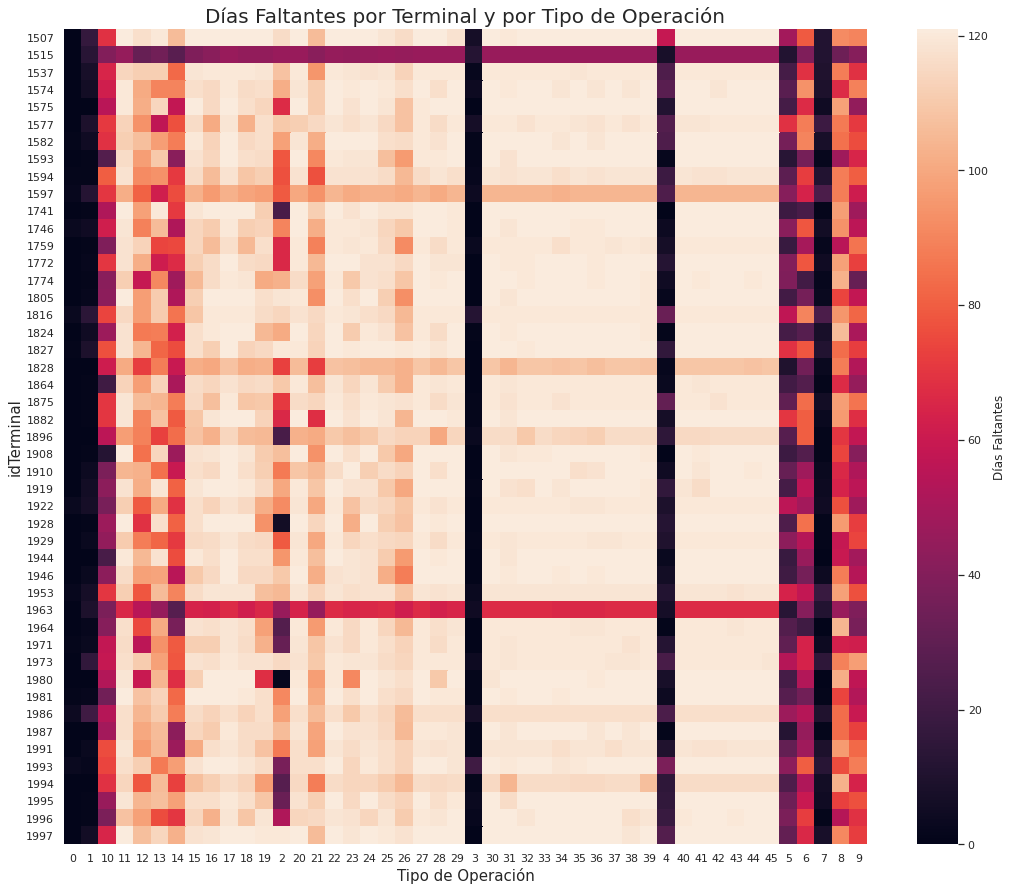

In [14]:
sns.set(rc={'figure.figsize':(18,15)})
pivot_table_ = pd.pivot_table(data,values='dia_semana',index=['YYMMDD','idTerminal'],columns='oper', aggfunc='count')
pivot_table_[pivot_table_>0]=0
pivot_table_.fillna(1,inplace=True)
pivot_table_.reset_index(inplace=True)
pivot_table_.drop(columns=['YYMMDD'],inplace=True)
dicts = {}
keys = pivot_table_.columns[1:]
values=['sum' for a in range(1,len(pivot_table_.columns[1:]))]
for i in keys:
    for x in values:
        dicts[i] = x
pivot_table_=pivot_table_.groupby('idTerminal').agg(dicts)
ax = sns.heatmap(pivot_table_, annot=False,cbar_kws={'label': 'Días Faltantes'})
plt.title('Días Faltantes por Terminal y por Tipo de Operación', fontsize = 20)
plt.xlabel('Tipo de Operación', fontsize = 15)
plt.ylabel('idTerminal', fontsize = 15)
plt.show()


#### La matriz indica que son pocos los tipos de operación que realmente se realizan casi de manera diaria. Al contrarío de las terminales que realizan transacciones de manera similar todos los días por tipo de operación, aunque hay 4 terminales (1515, 1597, 1828, 1963) que tienen menos días faltantes (días en que la cantidad de transacciones es 0 por tipo de operación). Esta matríz se puede reforzar con unos gráficos de pareto para verificar si hay tipos de transacción que concentren mas cantidad de transacciones al igual que si hay terminales que concentren más transacciones que otras. Antes de realizar los gráficos se mirará la relación del tipo de operación por cantidad de transacciones.

## Relación de la cantidad de transacciones con el tipo de operación. Validación de la distribución de los datos por tipo de operación y si cada una tiene outliers

In [15]:
tabla = data.groupby(['YYMMDD','oper']).agg({'idTerminal':'count'})
tabla.rename(columns={'idTerminal':'Cantidad Transacciones'},inplace=True)
tabla.reset_index(inplace=True)
tabla.head()

,YYMMDD,oper,Cantidad Transacciones
0,2017-01-31,0,3329
1,2017-01-31,1,700
2,2017-01-31,10,46
3,2017-01-31,11,1
4,2017-01-31,12,8


Text(0.5, 1.0, 'Boxplot Cantidad de transacciones Tipo de Operación')

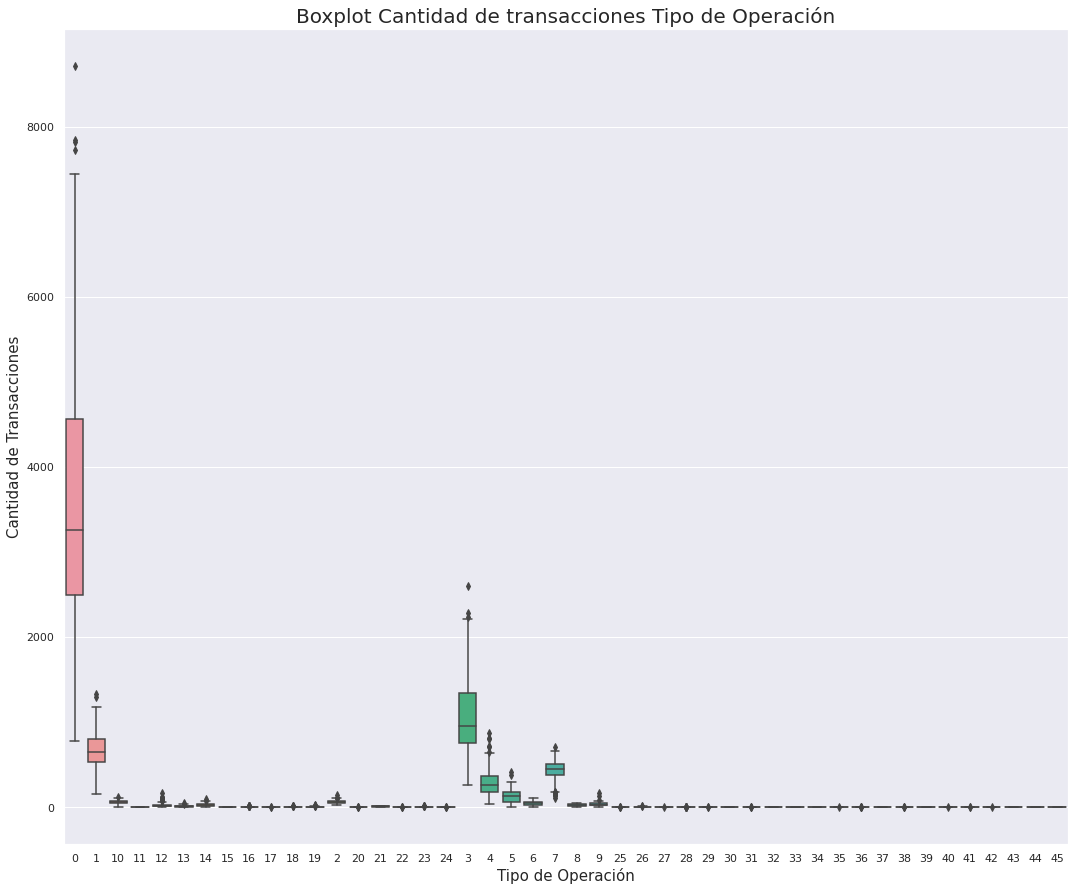

In [16]:
sns.boxplot(x='oper', y='Cantidad Transacciones',data=tabla)
plt.xlabel('Tipo de Operación', fontsize = 15)
plt.ylabel('Cantidad de Transacciones', fontsize = 15)
plt.title('Boxplot Cantidad de transacciones Tipo de Operación', fontsize = 20)

#### Se identifica una concentración de valumen de transacciones en 6 o 7 tipos de operación. También se identifican que son pocos los valores atípicos por tipo de operación, es decir son pocos los días que salen del comportamiento normal de la serie de tiempo.

# Construcción de gráficas de pareto para terminales y tipo de operaciones.

In [17]:
data1 = data.groupby('oper').agg({'idTerminal':'count'})
data2 = data.groupby('idTerminal').agg({'oper':'count'})
data1.rename(columns={'idTerminal':'Cantidad de Transacciones'},inplace=True)
data2.rename(columns={'oper':'Cantidad de Transacciones'},inplace=True)

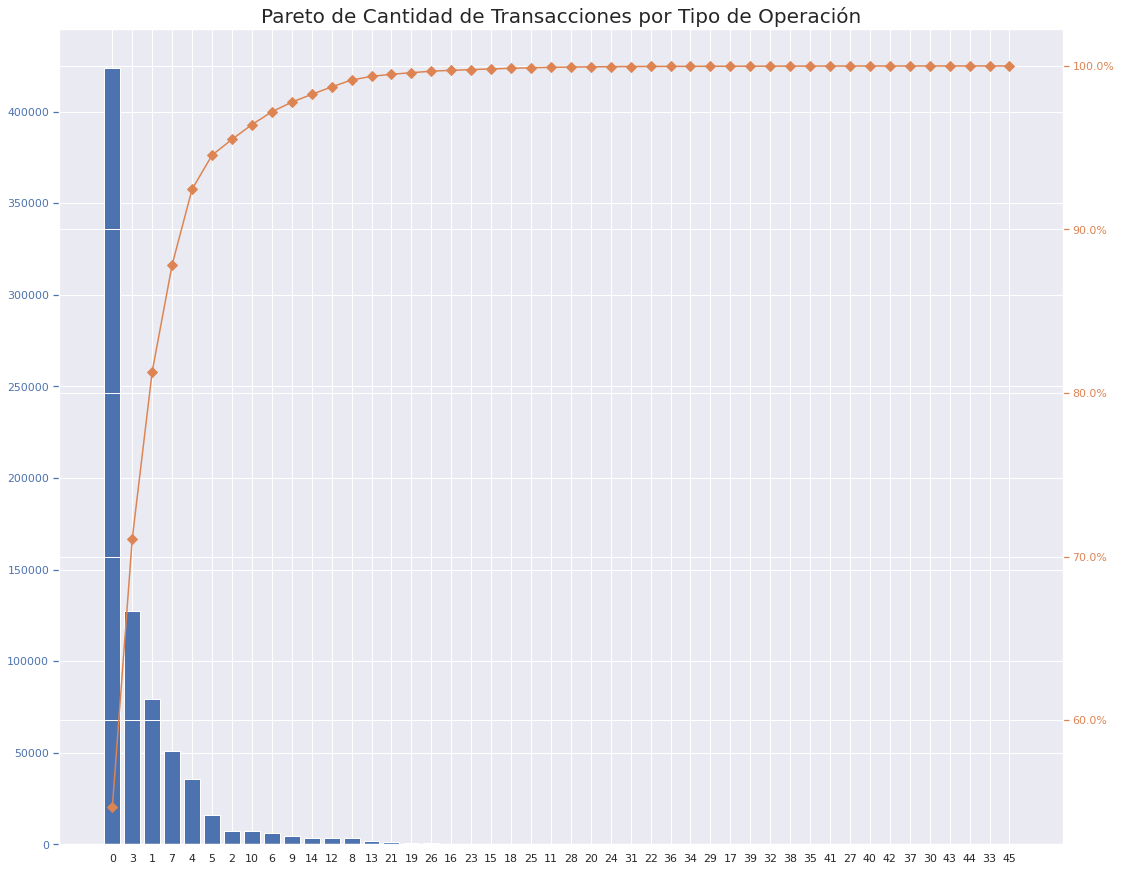

In [18]:
data1 = data1.sort_values(by='Cantidad de Transacciones',ascending=False)
data1["Porcentaje"] = data1["Cantidad de Transacciones"].cumsum()/data1["Cantidad de Transacciones"].sum()*100

fig, ax = plt.subplots()
ax.bar(data1.index, data1["Cantidad de Transacciones"], color="C0")
ax2 = ax.twinx()
ax2.plot(data1.index, data1["Porcentaje"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
plt.title('Pareto de Cantidad de Transacciones por Tipo de Operación',fontsize = 20)
plt.show()

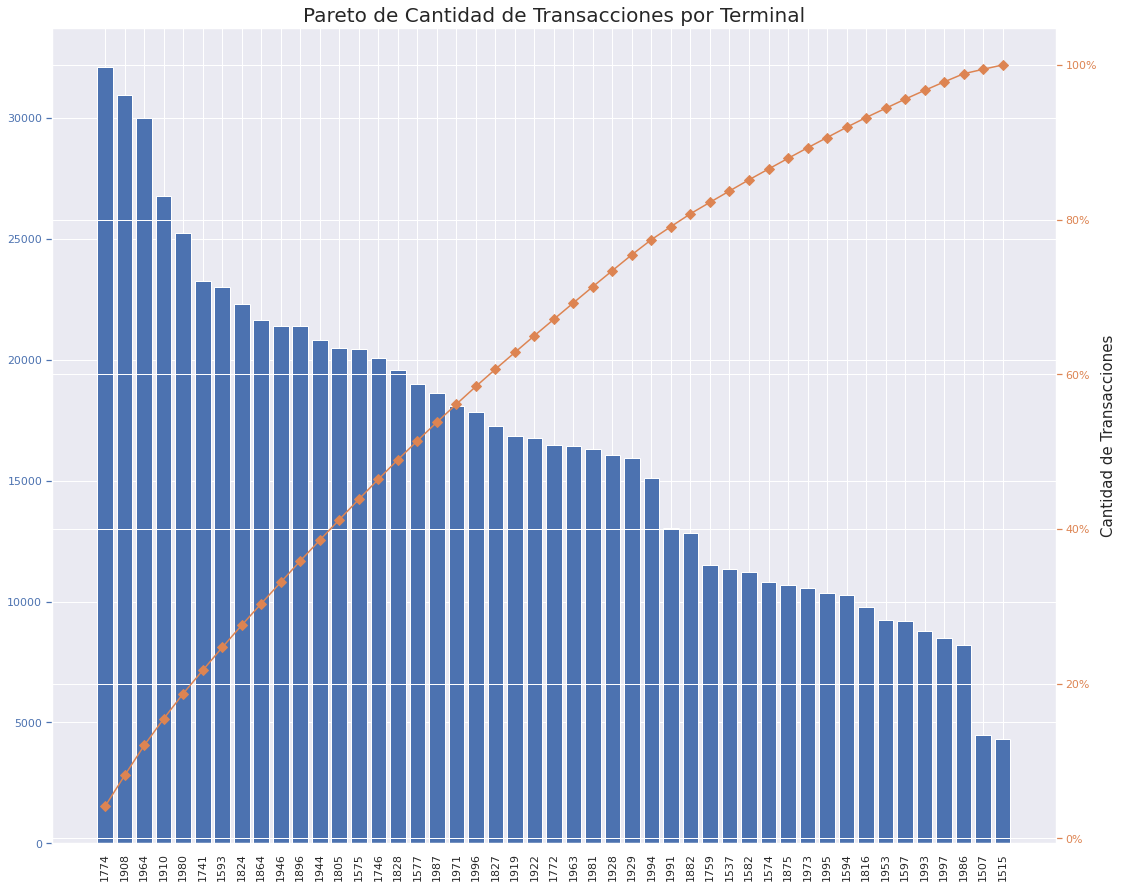

In [19]:
data2 = data2.sort_values(by='Cantidad de Transacciones',ascending=False)
data2["Porcentaje"] = data2["Cantidad de Transacciones"].cumsum()/data2["Cantidad de Transacciones"].sum()*100

fig, ax = plt.subplots()
ax.bar(data2.index, data2["Cantidad de Transacciones"], color="C0")
plt.xticks(rotation='vertical')
ax2 = ax.twinx()
ax2.plot(data2.index, data2["Porcentaje"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
plt.title('Pareto de Cantidad de Transacciones por Terminal',fontsize = 20)
plt.ylabel('Cantidad de Transacciones', fontsize = 15)
plt.show()

#### Selección de terminales y tipos de operación.

La selección de los tipos de operación se hace basado en que solo son 6 las terminales con las que se logra el 90% del volumen transaccional de la entidad bancaria. Por lo tanto al elegir los 5 primeros tipos de operación de la gráfica de pareto 1, estamos asegurando trabajar o predecir el 90% del volumen transaccional. 

La selección de las terminales no es tan diciente como en el gráfico de pareto por tipo de operación, pero al igual que este, se van a tomas los 5 más representativos en volumen transacional.

# 3. Analisis de series de tiempo elegidas

En este paso se analizaran las 10 series de tiempo elegidas, para identificar sus caracteríscticas y que sirvan como insumo para la constraucción de diferentes modelos.

In [20]:
data_series = data.copy()

Filtrando por las 5 terminales elegidas y los 5 tipos de operación elegidos.

In [21]:
operaciones=[a for a in data1.index[0:5].values]
terminales=[a for a in data2.index[0:5].values]

In [22]:
data_series = data_series[(data_series['oper'].isin(operaciones))&(data_series['idTerminal'].isin(terminales))]
data_series.reset_index(inplace=True,drop=True)

Se construyen 4 funciones con el siguiente objetivo:

- Gráfica de promedios móviles: Permitirá identificar tendencia de la seríe. También se incluye una variación de la ventada temporal que ayudará a identificar posibles comportamientos estacioneales.
- Gráficas de auto correlación y autocorrelación parcial: Permitiran ver la relación de la serie temporal con diferentes corrimientos en el tiempo, o desfases temporales e identificar valores pico de autocorrelación.
- Grafica de descomposición: Permitirá descomponer o caractarizar la serie de tiempo, como herramienta visual para ver tendencia, estacionalidad, ruido.
- Se realiza una prueba de Dickey-Fuller para con un grado de certeza del 95% decir si la serie tiene raiz unitaria y definir si tiene o no estacionalidad y de esta forma usar un modelo ARIMA o SARIMA.

In [23]:
def plotPromedioMovil(series, window, plot_intervals=False, scale=1.96, 
                      plot_anomalies=False):

    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Media Movil\n Tamaño de la ventana = {}".format(window))
    plt.plot(rolling_mean, "g", label="Tendencia Media Móvil")

    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Límite Superior / Límite Inferior")
        plt.plot(lower_bond, "r--")
        
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Valores Actuales")
    plt.legend(loc="upper left")
    plt.grid(True)

In [24]:
def tsplot(y, lags=None, figsize=(13, 5), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [25]:
def tsplot_(y, lags=None, figsize=(13, 5), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Tunning Serie de Tiempo\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [40]:
@interact
def series_analisis(Terminal=data_series['idTerminal'].unique(),Operacion=data_series['oper'].unique(),window=(1, 30, 1)):
    info = data_series[(data_series['idTerminal']==Terminal)&(data_series['oper']==Operacion)]
    tabla = info.groupby(['YYMMDD','idTerminal','oper']).agg({'dia_semana':'count'}).reset_index()
    tabla.rename(columns={'dia_semana':'Cantidad Transacciones'},inplace=True)
    pivot_table = pd.pivot_table(tabla,values='Cantidad Transacciones',index='YYMMDD',columns='oper', aggfunc=np.sum)
    pivot_table.rename(columns={Operacion:'Cantidad Transacciones'},inplace=True)
    idx = pd.date_range(pivot_table.index.min(), pivot_table.index.max())
    pivot_table=pivot_table.reindex(idx, fill_value=0)
    X = pivot_table['Cantidad Transacciones'].values
    result = sm.tsa.stattools.adfuller(X)
    if result[1]<0.05: 
        rta='Rechazo H0. La serie de tiempo No tiene una raíz unitaria, entonces es estacionaria'
    else:
        rta='No Rechazo Ho. La serie de tiempo tiene una raíz unitaria, entonces no es estacionaria'
    print('')
    print('Prueba de Dickey-Fuller test')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print(rta)
    descomposicion = sm.tsa.seasonal_decompose(pivot_table['Cantidad Transacciones'],model='additive')  
 
    return plotPromedioMovil(pivot_table,window,plot_intervals=True, plot_anomalies=True),tsplot(pivot_table['Cantidad Transacciones'], lags=59),descomposicion.plot()


interactive(children=(Dropdown(description='Terminal', options=('1964', '1908', '1980', '1910', '1774'), value…

Analisis (Terminal, Tipo Operacion):


1964-3 : No se identifica una tendencia marcada, tal vez algo decreciente en los últimos dos meses de la serie. La prueba de hipotesis indica que la serie tiene un componente estacional. Visualmente se identifica estacionalidad quincenal que en los dos últimos meses se va perdiendo. Se identifica un valor atípico el 2017-03-01. Existe una correlación significativa en el desfase 1 seguida de correlaciones que no son significativas hasta el desfase 14 y 28. Este patrón indica un término autorregresivo de orden 1.


1964-0 : No se identifica una tendencia marcada, tal vez algo decreciente en los últimos dos meses de la serie. La prueba de hipotesis indica que la serie tiene un componente estacional. Visualmente se identifica estacionalidad quincenal que en los dos últimos meses se va perdiendo. Se identifica un valor atípico a finales de marzo. Existe una correlación significativa en el desfase 1 seguida de correlaciones que no son significativas hasta el desfase 14 y 28. Este patrón indica un término autorregresivo de orden 1.


1964-4 : No se identifica una tendencia marcada, tal vez algo decreciente en los últimos dos meses de la serie. La prueba de hipotesis indica que la serie tiene un componente estacional. Visualmente se identifica estacionalidad quincenal que apartir de inicios de abril se va perdiendo. Existe una correlación significativa en el desfase 1 seguida de correlaciones que no son significativas hasta el desfase 14 y 28. Este patrón indica un término autorregresivo de orden 1.

1964-1 : Se comporta parecido a la serie anterior.

1964-7 : No se identifica una tendencia marcada, tal vez algo decreciente en los últimos dos meses de la serie. La prueba de hipotesis indica que la serie tiene un componente estacional. Visualmente se identifica no se identifica estacionalidad. Existe una correlación algo significativa en el desfase 5 seguida de correlaciones que no son significativas. Este patrón indica un término autorregresivo de orden 5.

## Se genera una función de tunning que permita eliminar los diferentes componentes a través de diferencia de desfases.

In [41]:
@interact
def series_tunning(Terminal=data_series['idTerminal'].unique(),Operacion=data_series['oper'].unique(),PeriodoEstacional=(1, 30, 1)):
    info = data_series[(data_series['idTerminal']==Terminal)&(data_series['oper']==Operacion)]
    tabla = info.groupby(['YYMMDD','idTerminal','oper']).agg({'dia_semana':'count'}).reset_index()
    tabla.rename(columns={'dia_semana':'Cantidad Transacciones'},inplace=True)
    pivot_table = pd.pivot_table(tabla,values='Cantidad Transacciones',index='YYMMDD',columns='oper', aggfunc=np.sum)
    pivot_table.rename(columns={Operacion:'Cantidad Transacciones'},inplace=True)
    idx = pd.date_range(pivot_table.index.min(), pivot_table.index.max())
    pivot_table=pivot_table.reindex(idx, fill_value=0)
    serie_diff = pivot_table['Cantidad Transacciones'] - pivot_table['Cantidad Transacciones'].shift(PeriodoEstacional)
    return tsplot_(serie_diff[PeriodoEstacional:], lags=50)


interactive(children=(Dropdown(description='Terminal', options=('1964', '1908', '1980', '1910', '1774'), value…

#### Se debe generar un proceso iterativo para elegir de manera automatica los mejores modelos ya que elegir los componentes manualmente toma bastante tiempo. Para elegir entre un modelo ARIMA o SARIMA, se tomará como referencia la prueba de Dickey-Fuller.

# 4. Construcción de Modelos.

En la construcción de los modelos se realiza una partición de 80 % de datos para training y 20 % para test, con el fín del validar la precisión del modelo.

# Construcción de modelos con series clasicas ARIMA y SARIMA

En este paso se construiran modelos clasicos de series temporales. 

In [28]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [29]:
def optimizeSARIMA(serie,parameters_list, d, D, s):
    
    results = []
    best_error = float("inf")

    for param in tqdm_notebook(parameters_list):
        try:
            model=sm.tsa.statespace.SARIMAX(serie, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
            
        except:
            continue
        data = serie.copy()
        data.columns = ['actual']
        data['sarima_model'] = model.fittedvalues
        data['sarima_model'][:s+d] = np.NaN
        forecast = model.predict(start = data.shape[0], end = data.shape[0]+15)
        forecast = data.sarima_model.append(forecast)
        error = mean_absolute_percentage_error(data['actual'][s+d:], data['sarima_model'][s+d:])
        if error < best_error:
            best_model = model
            best_error = error
            best_param = param
        results.append([param, error])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'error']
    result_table = result_table.sort_values(by='error', ascending=True).reset_index(drop=True)
    
    return result_table

In [30]:
def plotSARIMA(series, model, n_steps,s,d):
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['sarima_model'] = model.fittedvalues
    data['sarima_model'][:s+d] = np.NaN
    
    # Pronostico de n periodos de tiempo
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.sarima_model.append(forecast)
    # Calculando error.
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['sarima_model'][s+d:])
    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

In [31]:
@interact_manual
def training_model(Arima=False,Sarima=True,Archivo=True,Terminal=data_series['idTerminal'].unique(),Operacion=data_series['oper'].unique(),ps=(1,15,1),d=(0,2,1),qs=(1,15,1),Ps=(1,15,1) ,D=(0,2,1),Qs=(1,15,1),s=(1,30,1),dias_predecir=(1,30,1),gap_range=2):

    ps_ = range(1 if ps-3<1 else ps-3, ps) #Ultimo valor significativo PAFC
    d_=abs(d) 
    qs_ = range(1 if qs-3<1 else qs-3, qs) #Ultimo valor significativo AFC
    Ps_ = range(1 if Ps-3<1 else Ps-3, Ps) #Periodos estacionales significativos
    D_=D
    Qs_ = range(1 if Qs-3<1 else Qs-3, Qs)
    s_ = s # estacionalidad

    #creando lista con las combinación de parametros
    parameters = product(ps_, qs_, Ps_, Qs_)
    parameters_list = list(parameters)
    serie=data_series[(data_series['idTerminal']==Terminal)&(data_series['oper']==Operacion)].groupby('YYMMDD').agg({'dia_semana':'count'})
    serie.rename(columns={'dia_semana':'Cantidad TRX'},inplace=True)
    idx = pd.date_range(serie.index.min(), serie.index.max())
    serie=serie.reindex(idx, fill_value=0)
    serie=serie.reset_index()
    serie=serie.set_index('index').asfreq('d')
    serie['Cantidad TRX']=serie['Cantidad TRX'].astype('int')
    result_table = optimizeSARIMA(serie,parameters_list, d_, D, s_)
    p, q, P, Q = result_table.parameters[0]

    best_model=sm.tsa.statespace.SARIMAX(serie['Cantidad TRX'], order=(p, d_, q), 
                                            seasonal_order=(P, D, Q, s_)).fit(disp=-1)
    
#    dict_resul={'Serie':str(Terminal)+'-'+str(Operacion),'Modelo':'Sarima','MAPE':result_table['error']}
#    with open('resultados.json', 'w') as file:
#        file.write(json.dumps(mydict, ensure_ascii=False))
    return best_model.summary(),tsplot_(best_model.resid[dias_predecir+1:], lags=50),plotSARIMA(serie, best_model, dias_predecir,s_,d_)

interactive(children=(Checkbox(value=False, description='Arima'), Checkbox(value=True, description='Sarima'), …

# Entrenando una red neuronal monocapa

Se construye una red nueronal monocapa con conexión densa y se entrenan con los hiperparametros por defecto para ver el comportamiento. La construcción de esta red se hace como si fuera un modelo supervisado, donde la y esta determinada por y-t periodos anteriores. Por ejemplo se puede crear un modelo supervisado donde el valor de dia 7 esta determinado por los 6 días anteriores, o el día 15 esta determinado por los 14 días anteriores. Esta ventana de tiempo es movil.

El número de neuronas asignadas esta en función de las variables. Se agrega un call de parada temprana, donde se monitorea la función de perdida del conjunto de validación, con el fin de evitar overfitting en el entrenamiento. Como valor de selección del mejor modelo se utilizará el MAPE.

In [32]:
#Función para construir la matriz del modelo supervisado
def serie_supervisada(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('y%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('y%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('y%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [33]:
# Función de predicción
def agregarNuevoValor(x_test,newVal):
    arr=[]
    for i in x_test[0][0][1:x_test.shape[2]]:
        arr.append(i)
    arr.append(newVal[0][0])
    arr=pd.DataFrame(arr).values
    arr=np.array([arr])
    arr=arr.reshape((arr.shape[0], 1, arr.shape[1]))
    x_test=arr
    return x_test

In [34]:
@interact_manual
def construccion_RN(Archivo=True,Terminal=data_series['idTerminal'].unique(),Operacion=data_series['oper'].unique(),Input_features=(1,30,1),batch_size=(1,20,1),dias_predecir=(1,30,1)):
    serie=data_series[(data_series['idTerminal']==Terminal)&(data_series['oper']==Operacion)].groupby('YYMMDD').agg({'dia_semana':'count'})
    serie.rename(columns={'dia_semana':'Cantidad TRX'},inplace=True)
    idx = pd.date_range(serie.index.min(), serie.index.max())
    idx_ = pd.date_range(data_series['YYMMDD'].min(), data_series['YYMMDD'].max()+np.timedelta64(dias_predecir,'D'))
    serie=serie.reindex(idx, fill_value=0)
    serie=serie.reset_index()
    serie=serie.set_index('index').asfreq('d')
    serie['Cantidad TRX']=serie['Cantidad TRX'].astype('float32')
    values = serie['Cantidad TRX'].values
    values = values.astype('float32')
    scaler = MinMaxScaler(feature_range=(-1, 1))
    values=values.reshape(-1, 1) 
    scaled = scaler.fit_transform(values)
    reframed = serie_supervisada(scaled, Input_features, 1)  
    train_size=len(reframed)*0.8
    values = reframed.values
    train,test  = values[:int(train_size), :],values[int(train_size):, :]
    x_train, y_train = train[:, :-1], train[:, -1]
    x_test, y_test = test[:, :-1], test[:, -1]
    x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
    x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
    tf.keras.optimizers.Adam(
    learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)
    
    model=Sequential()
    model.add(Dense(Input_features,input_shape=(1,Input_features), activation='linear'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mae',optimizer='adam',metrics=['mse'])
    
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,mode='min')


    history=model.fit(x_train,y_train,
                     epochs=100,
                     batch_size=batch_size,
                     validation_split=0.1,
                     callbacks=[es],
                     shuffle=False, verbose=0)
    plt.plot(history.history['loss'],label='Training Loss')
    plt.plot(history.history['val_loss'],label='Validation Loss')
    plt.title('Validación Función de Perdida', fontsize=20)
    plt.xlabel('Epochs', fontsize=20)
    plt.ylabel('Loss Value', fontsize=20)
    plt.legend(fontsize=10)
    plt.show()
    testPredict = model.predict(x_test)
    testPredict=[a[0][0] for a in testPredict]
    testPredict = scaler.inverse_transform(np.array(testPredict).reshape(1, -1))
    trainPredict = model.predict(x_train)
    trainPredict=[a[0][0] for a in trainPredict]
    trainPredict = scaler.inverse_transform(np.array(trainPredict).reshape(1, -1))
    y_train = scaler.inverse_transform([y_train])
    y_test = scaler.inverse_transform([y_test])
    serie.reset_index(inplace=True)
    
    predicciones_train=pd.DataFrame(trainPredict[0])
    valores_train=pd.DataFrame(y_train[0])
    predicciones_train.set_index(serie['index'].iloc[:x_train.shape[0]],inplace=True)
    valores_train.set_index(serie['index'].iloc[:x_train.shape[0]],inplace=True)
    
    predicciones_test=pd.DataFrame(testPredict[0])
    valores_test=pd.DataFrame(y_test[0])
    predicciones_test.set_index(serie['index'].iloc[x_train.shape[0]+Input_features:],inplace=True)
    valores_test.set_index(serie['index'].iloc[x_train.shape[0]+Input_features:],inplace=True)
    error = mean_absolute_percentage_error(valores_test, predicciones_test)
    
    results=[]
    incio=x_test[-1:]
    for i in range(dias_predecir):
        parcial=model.predict(incio)
        parcial_=scaler.inverse_transform(parcial[0])
        results.append(parcial_[0][0])
        incio=agregarNuevoValor(incio,parcial[0])
    result=pd.DataFrame(results)[0]

    
    plt.plot(idx.values,serie['Cantidad TRX'],c='b', label='Serie Original')
    plt.plot(idx_[len(x_train)+Input_features:len(serie)].values,testPredict[0],c='r', label='Predicción Test')
    plt.plot(idx_[:len(x_train)].values,trainPredict[0],c='y', label='Predicción Train')
    plt.plot(idx_[len(serie):len(idx_)].values,result,c='m', label='Predicción 15 Dias')
    plt.xticks(rotation=90)
    plt.legend(fontsize=10)
    plt.title('Resultados del Modelo', fontsize=20)
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error), fontsize=20)
    plt.xlabel('Días', fontsize=20)
    plt.ylabel('Cantidad de Transacciones', fontsize=20)
    plt.show()

interactive(children=(Checkbox(value=True, description='Archivo'), Dropdown(description='Terminal', options=('…

# Entrenando un modelo de regresión con XGBoots

In [35]:
@interact_manual
def construccion_XGBoots(Archivo=True,Terminal=data_series['idTerminal'].unique(),Operacion=data_series['oper'].unique(),Input_features=(1,30,1),dias_predecir=(1,30,1)):
    serie=data_series[(data_series['idTerminal']==Terminal)&(data_series['oper']==Operacion)].groupby('YYMMDD').agg({'dia_semana':'count'})
    serie.rename(columns={'dia_semana':'Cantidad TRX'},inplace=True)
    idx = pd.date_range(serie.index.min(), serie.index.max())
    idx_ = pd.date_range(data_series['YYMMDD'].min(), data_series['YYMMDD'].max()+np.timedelta64(dias_predecir,'D'))
    serie=serie.reindex(idx, fill_value=0)
    serie=serie.reset_index()
    serie=serie.set_index('index').asfreq('d')
    serie['Cantidad TRX']=serie['Cantidad TRX'].astype('float32')
    values = serie['Cantidad TRX'].values
    values = values.astype('float32')
    scaler = MinMaxScaler(feature_range=(-1, 1))
    values=values.reshape(-1, 1) 
    scaled = scaler.fit_transform(values)
    reframed = serie_supervisada(scaled, Input_features, 1)  
    train_size=len(reframed)*0.8
    values = reframed.values
    train,test  = values[:int(train_size), :],values[int(train_size):, :]
    x_train, y_train = train[:, :-1], train[:, -1]
    x_test, y_test = test[:, :-1], test[:, -1]
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1]))
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1]))
    model = xg.XGBRegressor(objective='reg:squarederror', learning_rate=0.002, max_depth=10, n_estimators=1000)
    model.fit(x_train, y_train)
    testPredict=model.predict(x_test)           
    trainPredict = model.predict(x_train)
    testPredict=[a for a in testPredict]
    testPredict = scaler.inverse_transform(np.array(testPredict).reshape(1, -1))
    trainPredict=[a for a in trainPredict]
    trainPredict = scaler.inverse_transform(np.array(trainPredict).reshape(1, -1))
    y_train = scaler.inverse_transform([y_train])
    y_test = scaler.inverse_transform([y_test])

    error = mean_absolute_percentage_error(y_test[0], testPredict[0])
    
    results=[]
    incio=x_test[-1:].reshape(1, 1, x_test.shape[1])
    for i in range(dias_predecir):
        parcial=model.predict(incio[0])
        parcial_=scaler.inverse_transform(parcial.reshape(-1, 1))
        results.append(parcial_[0][0])
        incio=agregarNuevoValor(incio,parcial.reshape(-1, 1))
    result=pd.DataFrame(results)[0]

    plt.plot(idx.values,serie['Cantidad TRX'],c='b', label='Serie Original')
    plt.plot(idx_[len(x_train)+Input_features:len(serie)].values,testPredict[0],c='r', label='Predicción Test')
    plt.plot(idx_[:len(x_train)].values,trainPredict[0],c='y', label='Predicción Train')
    plt.plot(idx_[len(serie):len(idx_)].values,result,c='m', label='Predicción 15 Dias')
    plt.xticks(rotation=90)
    plt.legend(fontsize=10)
    plt.title('Resultados del Modelo', fontsize=20)
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error), fontsize=20)
    plt.xlabel('Días', fontsize=20)
    plt.ylabel('Cantidad de Transacciones', fontsize=20)
    plt.show()
     
    
    return reframed.head()

interactive(children=(Checkbox(value=True, description='Archivo'), Dropdown(description='Terminal', options=('…

# Series multivariadas con redes neuronales

Es este caso se construirá un modelo de predicción que tendrá como inputs las series temporales de las terminales y tipos de operación elegidos. Estos nos ayudaran para predecir el total de transacciones (suma de estas series temporales), para los próximos 15 días.

In [36]:
def series_seq(x,y, n_steps):
    X_, y_ = list(), list()
    for i in range(len(x)):
        end_ix = i + n_steps
        if end_ix > len(x):
             break
        seq_x, seq_y = x[i:end_ix], y[end_ix-1]
        X_.append(seq_x)
        y_.append(seq_y)
    return np.array(X_), np.array(y_)

In [37]:
tabla_multi=data_series.groupby(['YYMMDD','idTerminal','oper']).agg({'dia_semana':'count'})
tabla_multi=tabla_multi.unstack().fillna(0)
tabla_multi=tabla_multi.unstack(1).fillna(0)
tabla_multi=tabla_multi.stack()
tabla_multi=tabla_multi.stack()
tabla_multi

dia_semana
YYMMDD     idTerminal oper            
2017-01-31 1774       0            6.0
                      1            5.0
                      3            5.0
                      4            0.0
                      7            0.0
...                                ...
2017-05-31 1980       0          248.0
                      1           69.0
                      3           85.0
                      4           17.0
                      7           26.0

[3025 rows x 1 columns]

In [38]:
@interact_manual
def construccion_RN_Multi(Archivo=True,Input_features=(1,30,1),dias_predecir=(1,30,1)):
    idx = pd.date_range(data_series['YYMMDD'].min(), data_series['YYMMDD'].max())
    idx_ = pd.date_range(data_series['YYMMDD'].min(), data_series['YYMMDD'].max()+np.timedelta64(dias_predecir,'D'))

    data=[]
    for a in idx:
        data.append(np.array([a[0] for a in tabla_multi[tabla_multi.index.get_level_values(0)==str(a)[0:10]].values]).reshape(1,25)[0])
    suma=[[a.sum()] for a in data]
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_scaled = scaler.fit_transform(data)
    suma_scaled = scaler.fit_transform(suma)
    X, y =series_seq(data_scaled,suma_scaled,Input_features)
    train_size=len(X)*0.8
    x_train,x_test  = X[:int(train_size), :],X[int(train_size):, :]
    y_train,y_test  = y[:int(train_size), :],y[int(train_size):, :]
    n_input_tra = x_train.shape[1] * x_train.shape[2]
    x_train = x_train.reshape((x_train.shape[0], n_input_tra))
    n_input_tes = x_test.shape[1] * x_test.shape[2]
    x_test = x_test.reshape((x_test.shape[0], n_input_tes))
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,mode='min')
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=n_input_tra))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    history=model.fit(x_train, y_train, epochs=100, verbose=0,validation_split=0.1,callbacks=[es])
    plt.plot(history.history['loss'],label='Training Loss')
    plt.plot(history.history['val_loss'],label='Validation Loss')
    plt.title('Validación Función de Perdida', fontsize=20)
    plt.xlabel('Epochs', fontsize=20)
    plt.ylabel('Loss Value', fontsize=20)
    plt.legend(fontsize=10)
    plt.show()

    y_pred=model.predict(x_test)
    y_pred_train=model.predict(x_train)
    error = mean_absolute_percentage_error(scaler.inverse_transform(y_test), scaler.inverse_transform(y_pred))
    results=[]
    incio=x_test[-1:].reshape(1, 1, x_test.shape[1])
    for i in range(dias_predecir):
        parcial=model.predict(incio[0])
        parcial_=scaler.inverse_transform(parcial.reshape(-1, 1))
        results.append(parcial_[0][0])
        incio=agregarNuevoValor(incio,parcial.reshape(-1, 1))
    result=pd.DataFrame(results)[0]
    for a in tabla_multi.index.get_level_values(1).unique():
        for b in tabla_multi.index.get_level_values(2).unique():
            plt.plot(idx.values,tabla_multi[(tabla_multi.index.get_level_values(1)==a)&(tabla_multi.index.get_level_values(2)==b)].values,c='k')
    plt.plot(idx_[:len(X)+Input_features-1].values,suma,c='b', label='Suma de las series de tiempo escogidas')
    plt.plot(idx_[len(x_train)+Input_features-1:len(X)+Input_features-1].values,scaler.inverse_transform(y_pred),c='r', label='Predicción Test')
    plt.plot(idx_[:len(x_train)].values,scaler.inverse_transform(y_pred_train),c='y', label='Predicción Train')
    plt.plot(idx_[len(X)+Input_features-1:len(idx_)].values,result,c='m', label='Predicción 15 Dias')
    plt.xticks(rotation=90)
    plt.legend(fontsize=10)
    plt.title('Resultados del Modelo', fontsize=20)
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error), fontsize=20)
    plt.xlabel('Días', fontsize=20)
    plt.ylabel('Cantidad de Transacciones', fontsize=20)
    plt.show()
    

interactive(children=(Checkbox(value=True, description='Archivo'), IntSlider(value=15, description='Input_feat…